<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/FinancePortfolioOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
#Description: This program attempts to optimize a users portfolio using Efficient Frontier

In [186]:
#import python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
'''
#load the data
from google.colab import files
files.upload()
#store the data and print
df = pd.read_csv('NYSE_Close.csv')
#set the date as index
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
#remove the date column
df.drop(columns=['Date'], axis = 1, inplace = True)
df
#get the tickers
assets = df.columns
'''

In [188]:
#get stock symbol/tickers in the portfolio
#FAANG
assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG', 'TSLA']

In [189]:
#Assign weights to the stocks
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [190]:
#get the stock/portfolio starting date
stockStartDate = '2013-01-01'

In [191]:
#get the ending date
today = datetime.today().strftime('%Y-%m-%d')
today

'2021-05-09'

In [192]:
#create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

In [193]:
#store the adjusted close price of the stock into the df
for stock in assets:
  df[stock] = web.DataReader(stock, data_source='yahoo', start=stockStartDate, end=today)['Adj Close']

In [ ]:
#show the df
df

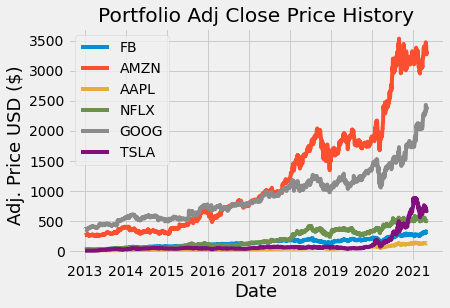

In [195]:
#visually show the stock/portfolio
title = 'Portfolio Adj Close Price History'

#get the stocks
my_stocks = df

#create and plot the graph
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c], label = c)

plt.title(title)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj. Price USD ($)', fontsize = 18)
plt.legend(my_stocks.columns.values, loc = 'upper left')
plt.show()

In [ ]:
#show the daily simple return
returns = df.pct_change()
returns

In [197]:
#create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,FB,AMZN,AAPL,NFLX,GOOG,TSLA
FB,0.118200,0.055077,0.045418,0.057034,0.050766,0.058794
AMZN,0.055077,0.092854,0.040361,0.063633,0.047601,0.058011
AAPL,0.045418,0.040361,0.082191,0.036095,0.038826,0.052503
NFLX,0.057034,0.063633,0.036095,0.209936,0.049399,0.074282
GOOG,0.050766,0.047601,0.038826,0.049399,0.066768,0.047662
TSLA,0.058794,0.058011,0.052503,0.074282,0.047662,0.320697


In [198]:
#Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.09766275061203177

In [199]:
#calulate the portfolio volatility aka standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.312510400806168

In [200]:
#calculate annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.49865050220896523

In [201]:
#show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + '%'

print('Expected annual return: ' + percent_ret)
print('Annual volatility/risks:' + percent_vols)
print('Annual variance' + percent_var)

Expected annual return: 50.0%
Annual volatility/risks:31.0%
Annual variance10.0%


In [202]:
#install the below package
#pip install PyPortfolioOpt

In [203]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [204]:
#Porfolio Optimization
#Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
s = risk_models.sample_cov(df)

#create Efficient Frontier Object
#optimize for max sharpe ratio
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('FB', 0.08979), ('AMZN', 0.22296), ('AAPL', 0.14187), ('NFLX', 0.26582), ('GOOG', 0.0), ('TSLA', 0.27956)])
Expected annual return: 49.8%
Annual volatility: 30.2%
Sharpe Ratio: 1.58


(0.4984100731885987, 0.30234441229193, 1.582334760421065)

In [205]:
#install the below package
#pip install pulp

In [206]:
#get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
total_portfolio_value = 5000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation , leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation: {'FB': 2, 'AAPL': 6, 'NFLX': 3, 'TSLA': 3}
Funds remaining: $51.95


In [207]:
#create a function to get the companies name
def get_company_name(symbol):
  url = 'http://d.yimg.com/autoc.finance.yahoo.com/autoc?query='+symbol+'&region=1&lang=en'
  result = requests.get(url).json()
  for r in result['ResultSet']['Result']:
    if r['symbol'] == symbol:
      return r['name']

In [208]:
#store the company name into a list
company_name = []
for symbol in allocation:
  company_name.append(get_company_name(symbol))

In [209]:
#get the discrete allocation values
discrete_allocation_list = []
for symbol in allocation:
  discrete_allocation_list.append(allocation.get(symbol))

In [210]:
#create a dataframe for the portfolio
portfolio_df = pd.DataFrame(columns = ['Company_name', 'Company_Ticker', 'Discrete_val_'+str(total_portfolio_value)])

In [211]:
portfolio_df['Company_name'] = company_name
portfolio_df['Company_Ticker'] = allocation
portfolio_df['Discrete_val_'+str(total_portfolio_value)] = discrete_allocation_list 
#show the portfolio
portfolio_df

,Company_name,Company_Ticker,Discrete_val_5000
0,"Facebook, Inc.",FB,2
1,Apple Inc.,AAPL,6
2,"Netflix, Inc.",NFLX,3
3,"Tesla, Inc.",TSLA,3
